In [1]:
## Figure 13 & 14 - Comparing PySAR Time-series and GIAnT Time-series

import os
import sys
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt, ticker
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pysar.simulation.plot import *
from pysar.objects import timeseries, ifgramStack, sensor
from pysar.utils import readfile, writefile, ptime, plot as pp, utils as ut, network as pnet
from pysar import view

work_dir = os.path.expanduser('~/development/python/2018_ComputGeosci_PySAR/pysar_vs_giant')
os.chdir(work_dir)
print('Go to directory: '+work_dir)

proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128')
proj_name = sensor.project_name2sensor_name(proj_dir)[1]

ts_files = [os.path.join(proj_dir, i) for i in ['GIANT/PYSAR/timeseries_ECMWF_demErr_ramp.h5',
                                                'GIANT/Stack/LS-PARAMS.h5',
                                                'GIANT/Stack/NSBAS-PARAMS.h5',
                                                'GIANT/Stack/TS-PARAMS.h5']]
vel_files = [os.path.join(proj_dir, i) for i in ['GIANT/PYSAR/velocity.h5',
                                                 'GIANT/LS-velocity.h5',
                                                 'GIANT/NSBAS-velocity.h5',
                                                 'GIANT/TS-velocity.h5']]
tcoh_file = os.path.join(proj_dir, 'GIANT/PYSAR/temporalCoherence.h5')
dem_file = os.path.join(proj_dir, 'PYSAR/INPUTS/geometryRadar.h5')
lut_file = os.path.join(proj_dir, 'PYSAR/INPUTS/geometryRadar.h5')
atr = readfile.read_attribute(ts_files[0])
coord = ut.coordinate(atr, lut_file)

## Points of Interest
pts_lalo = [
#            [-0.3749, -91.5336],    #Fernandina caldera, largest deformation          --> g-nsbas/pysar give result
            [-0.3706, -91.5418],    #Fernandina caldera, low temp coh                 --> g-nsbas/pysar give result, but pysar dropped due to low tcoh
            [-0.3637, -91.5287],    #Fernandina caldera, low coherent w unw err       --> g-sbas/nsbas overestimated due to unw err, g-timefun filering
            [-0.3750, -91.0781],    #Alcedo lava flow, low coherent w/o unw err       --> g-nsbas underestimated
            [-0.4369, -91.1162],    #Alcedo crater center, high coherent w/o unw err  --> all the same
           ]

#convert lalo to yx
pts_yx = []
for lat, lon in pts_lalo:
    y, x = coord.geo2radar(lat, lon)[0:2]
    pts_yx.append([y, x])

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pysar_vs_giant


In [2]:
## prepare histogram data
proj_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/'
proj_name = sensor.project_name2sensor_name(proj_dir)[1]

# PYSAR
num_pysar = readfile.read(os.path.join(proj_dir, 'GIANT/PYSAR/numInvIfgram.h5'))[0].flatten()
mask_pysar_out = readfile.read(os.path.join(proj_dir, 'GIANT/PYSAR/maskTempCoh.h5'))[0].flatten()
mask_pysar_in = num_pysar != 0.

# GIANT
num_giant = readfile.read(os.path.join(proj_dir, 'GIANT/Stack/NSBAS-PARAMS.h5'), datasetName='ifgcnt')[0].flatten()
num_giant_max = np.max(num_giant)
mask_gsbas = num_giant == num_giant_max
mask_gnsbas = num_giant != 0.
mask_gnsbas *= ~np.isnan(num_giant)
mask_gtimefun = np.array(mask_gsbas)

num_data = (num_pysar[mask_pysar_in],
            num_pysar[mask_pysar_out],
            num_giant[mask_gsbas],
            num_giant[mask_gnsbas],
            num_giant[mask_gtimefun])

save figure to vel_GalapagosSenDT128.png


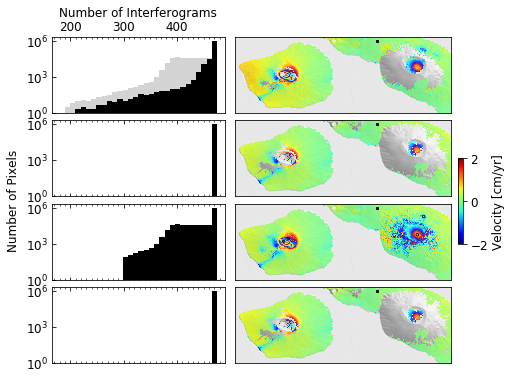

In [93]:
# Fig. 13 (a-h)

fig = plt.figure(figsize=(8, 6))
gs = GridSpec(4, 6, figure=fig)
axs1 = [fig.add_subplot(gs[0, 0:2]),
        fig.add_subplot(gs[1, 0:2]),
        fig.add_subplot(gs[2, 0:2]),
        fig.add_subplot(gs[3, 0:2])]
axs2 = [fig.add_subplot(gs[0, 2:]),
        fig.add_subplot(gs[1, 2:]),
        fig.add_subplot(gs[2, 2:]),
        fig.add_subplot(gs[3, 2:])]

## left - histogram
labels = ['PYSAR (processed)', 'PYSAR (selected)', 'G-SBAS', 'G-NSBAS', 'G-TimeFun']
for i in [0,1,2,3,4]:
    if i == 0:
        ax = axs1[0]
        ax.hist(num_data[i], bins=30, histtype='stepfilled', range=(180,num_giant_max), log=True,
                color='lightgray', lw=1, linestyle='dotted', label=labels[i])
    else:
        ax = axs1[i-1]
        ax.hist(num_data[i], bins=30, histtype='stepfilled', range=(180,num_giant_max), log=True,
                color='k', lw=1, label=labels[i])
# axis format
for ax in axs1:
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=False)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
    ax.set_ylim(bottom=1e0)
    if ax != axs1[0]:
        ax.get_xaxis().set_ticklabels([])
axs1[0].set_xlabel('Number of Interferograms', fontsize=font_size)
axs1[0].xaxis.set_label_position('top') 
axs1[0].xaxis.tick_top()
pp.set_shared_ylabel(axs1, 'Number of Pixels', font_size=font_size)


## right - velocity
# subset range
x0, x1 = 400, 1680
y0, y1 = 750, 1200
print_msg = False
for i in range(len(vel_files)):
    ax = axs2[i]
    cmd  = 'view.py {} velocity -d {} --dem-nocontour '.format(vel_files[i], dem_file)
    cmd += '--sub-x {} {} --sub-y {} {} '.format(x0, x1, y0, y1)
    cmd += '-u cm --wrap --wrap-range -2 2 -c jet '
    cmd += '--notitle --notick --ref-size 2 --nocbar --fontsize 12 '
    #print(cmd)
    d_v, atr, inps = view.prep_slice(cmd, print_msg=print_msg)
    ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps, print_msg=print_msg)
fig.subplots_adjust(hspace=0.1, wspace=-0.35)

# point of interest
xoff = [-60, -30, 80]
yoff = [ 60, -80, 30]
for i in range(len(pts_yx)):
    y, x = pts_yx[i]
    axs2[2].scatter(x-x0, y-y0, s=2.5**2, color='none', edgecolors='k', lw=0.8)

# colorbar
cax = fig.add_axes([0.83, 0.4, 0.01, 0.2])
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.locator = ticker.MaxNLocator(nbins=2)
cbar.update_ticks()
cbar.set_label('Velocity [cm/yr]', fontsize=font_size)

# save
out_file= 'vel_{}.png'.format(proj_name)
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to {}'.format(out_file))
plt.show()

save figure to vel_GalapagosSenDT128.png


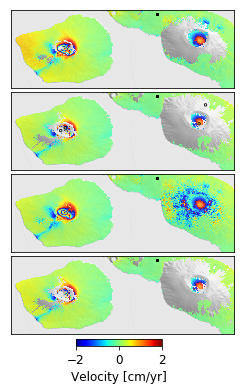

In [108]:
## Fig. 13a-d - Linear Velocity Map
# subset range
x0, x1 = 400, 1680
y0, y1 = 750, 1200
print_msg = False

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(4, 6))
for i in range(len(vel_files)):
    ax = axs.flatten()[i]
    cmd  = 'view.py {} velocity -d {} --dem-nocontour '.format(vel_files[i], dem_file)
    cmd += '--sub-x {} {} --sub-y {} {} '.format(x0, x1, y0, y1)
    cmd += '-u cm --wrap --wrap-range -2 2 '
    cmd += '--notitle --notick --ref-size 2 --nocbar --fontsize 12 '
    #print(cmd)
    d_v, atr, inps = view.prep_slice(cmd, print_msg=print_msg)
    ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps, print_msg=print_msg)
fig.subplots_adjust(hspace=0.02)

# colorbar
cax = fig.add_axes([0.35, 0.1, 0.3, 0.015])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=font_size)
cbar.locator = ticker.MaxNLocator(nbins=2)
cbar.update_ticks()
cbar.set_label('Velocity [cm/yr]', fontsize=font_size)

# point of interest
xoff = [-60, -30, 80]
yoff = [ 60, -80, 30]
for i in range(len(pts_yx)):
    y, x = pts_yx[i]
    axs.flatten()[1].scatter(x-x0, y-y0, s=2.5**2, color='none', edgecolors='k', lw=0.8)

## save figure
out_file= 'vel_{}.png'.format(proj_name)
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to {}'.format(out_file))
plt.show()

In [ ]:
## Run to get Points of Interest @ GIANT/Stack directory
tsview.py ../PYSAR/timeseries_ECMWF_demErr_ramp.h5 TS-PARAMS.h5 NSBAS-PARAMS.h5 TS-PARAMS.h5 --ylim -20 40 --label pysar g-sbas g-nsbas g-timefun --wrap --wrap-range -5 5 --zf -l ../../PYSAR/INPUTS/geometryRadar.h5 --yx 825 562

dropped: [[0.49636197]]


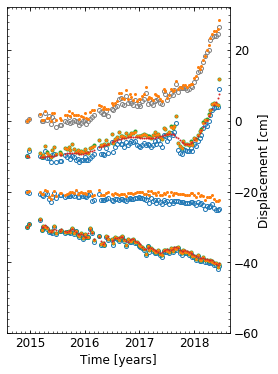

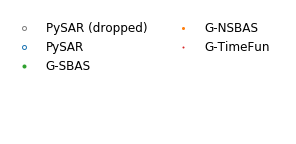

In [109]:
## Fig. 13e - Displacement time-series on pixels of interest

#plot setting
off = -10
unit_scales = [100., 0.1, 0.1, 0.1]
ms_list = np.array([4, 3, 2, 1])
colors = [pp.mplColors[0],
          pp.mplColors[2], 
          pp.mplColors[1], 
          pp.mplColors[3]]
labels = ['PySAR', 'G-SBAS', 'G-NSBAS', 'G-TimeFun']

def plot_one_pixel(ax, box, off=0.):
    for i in range(len(ts_files)):
        dis_ts = readfile.read(ts_files[i], box=box, print_msg=False)[0] * unit_scales[i]
        dis_ts -= dis_ts[0]
        # temp coh and masking
        pts_tcoh = readfile.read(tcoh_file, box=box, print_msg=False)[0]
        if i == 0:
            pts_mfc = 'none'
            if pts_tcoh < 0.7:
                pts_mec = 'gray'
                pts_label = 'PySAR (dropped)'
                print('dropped: {}'.format(pts_tcoh))
            else:
                pts_mec = colors[i]
                pts_label = labels[i]
        else:
            pts_mec = colors[i]
            pts_mfc = colors[i]
            pts_label = labels[i]
        ax.plot(dates, dis_ts+off, 'o', label=pts_label, ms=ms_list[i], mec=pts_mec, mfc=pts_mfc)
    return ax

# date info for plotting
atr = readfile.read_attribute(ts_files[0])
date_list = timeseries(ts_files[0]).get_date_list()
dates, datevector = ptime.date_list2vector(date_list)

# plot
fig, ax = plt.subplots(figsize=(4, 6))
for i in range(len(pts_yx)):
    y, x = pts_yx[i]
    ax = plot_one_pixel(ax, box=(x, y, x+1, y+1), off=off*i)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(10))
pp.auto_adjust_xaxis_date(ax, datevector, fontsize=font_size)
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.set_ylim(bottom=-60)
ax.set_xlabel('Time [years]', fontsize=font_size)
ax.set_ylabel('Displacement [cm]', fontsize=font_size, labelpad=-1)

# save figure
out_file= 'ts_{}.png'.format(proj_name)
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)

# plot legend on a different figure
handles, labels = ax.get_legend_handles_labels()
pts_handles = [handles[0], handles[4]] + handles[1:4]
pts_labels = [labels[0], labels[4]] + labels[1:4]

fig, ax = plt.subplots(figsize=[4, 2])
ax.axis('off')
plt.legend(pts_handles, pts_labels, loc='best', ncol=2, fontsize=font_size, frameon=False, borderaxespad=0.5)
plt.savefig('ts_{}_legend.png'.format(proj_name), bbox_inches='tight', transparent=True, dpi=fig_dpi)

plt.show()

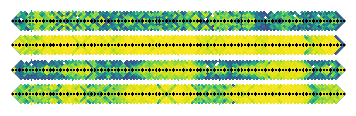

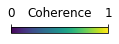

In [53]:
## Fig. 13e inset - plot coherence matrix of POIs

num_pts = len(pts_yx)
min_coh = 0.25

ifg_file = os.path.join(proj_dir, 'PYSAR/INPUTS/ifgramStack.h5')
stack_obj = ifgramStack(ifg_file)
stack_obj.open(print_msg=False)
date12_list = stack_obj.get_date12_list(dropIfgram=True)
dset_list = ['coherence-{}'.format(i) for i in date12_list]

fig, axs = plt.subplots(nrows=num_pts, ncols=1, figsize=[6, 2])
for i in range(num_pts):
    y, x = pts_yx[i]
    box = (x, y, x+1, y+1)
    coh = np.squeeze(readfile.read(ifg_file, datasetName=dset_list, box=box, print_msg=False)[0])
    # get date12_list_drop
    coh_date12_list = list(np.array(date12_list)[coh >= min_coh])
    date12_list_drop = [i for i in date12_list if i not in coh_date12_list]

    #plot
    ax = axs[i]
    ax, im = pp.plot_rotate_diag_coherence_matrix(ax, coh.tolist(), date12_list, date12_list_drop,
                                                  cmap='viridis', disp_min=0.0)

    # check matrix singularity
    A = stack_obj.get_design_matrix4timeseries_estimation(date12_list=coh_date12_list)[0]
    if np.linalg.matrix_rank(A) < A.shape[1]:
        print('Point {}: Singular design matrix!'.format(i))

fig.subplots_adjust(hspace=-0.3)
#plt.savefig('pysar_vs_giant_coh_mat.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)

# plot colorbar
fig = plt.figure(figsize=(1.5, 0.1))
cax = fig.add_axes([0.05, 0.05, 0.9, 0.9])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')

cbar.ax.tick_params(labelsize=font_size)
cbar.locator = ticker.MaxNLocator(nbins=1)
cbar.update_ticks()
cbar.set_label('Coherence', fontsize=font_size, labelpad=-10)
cbar.ax.xaxis.tick_top()
cbar.ax.xaxis.set_label_position('top') 
#plt.savefig('pysar_vs_giant_coh_mat_cbar.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)

plt.show()

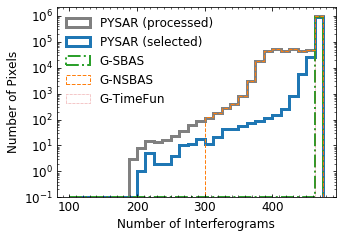

In [2]:
## Figure 14 - Histogram of pixels used in network inversion
proj_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/'
proj_name = sensor.project_name2sensor_name(proj_dir)[1]

mask_file = proj_dir+'GIANT/PYSAR/maskTempCoh.h5'
mask_tcoh = readfile.read(mask_file)[0].flatten()
num_pysar_file = proj_dir+'GIANT/PYSAR/numInvIfgram.h5'
num_pysar = readfile.read(num_pysar_file)[0].flatten()
#num_pysar[mask_tcoh == 0] = 0
mask_pysar_in = num_pysar != 0.

# GIANT
num_giant_file = proj_dir+'GIANT/Stack/NSBAS-PARAMS.h5'
num_giant = readfile.read(num_giant_file, datasetName='ifgcnt')[0].flatten()
num_giant_max = np.max(num_giant)

mask_gnsbas = num_giant != 0.
mask_gnsbas *= ~np.isnan(num_giant)
mask_gsbas = num_giant == num_giant_max
mask_gtimefun = np.array(mask_gsbas)

num_data = (num_pysar[mask_pysar_in], num_pysar[mask_tcoh], num_giant[mask_gsbas], num_giant[mask_gnsbas], num_giant[mask_gtimefun])
labels = ['PYSAR (processed)', 'PYSAR (selected)', 'G-SBAS', 'G-NSBAS', 'G-TimeFun']
linestyles = ('solid', 'solid', 'dashdot', 'dashed', 'dotted')
colors = ['gray',
          pp.mplColors[0],
          pp.mplColors[2], 
          pp.mplColors[1], 
          pp.mplColors[3]]
linewidths = [3, 3, 2, 1, 0.5]

fig, ax = plt.subplots(figsize=(5, 3.5))
for i in range(len(num_data)):
    ax.hist(num_data[i], bins=30, histtype='step', 
            range=(100,num_giant_max), log=True,
            color=colors[i],
            label=labels[i], lw=linewidths[i], linestyle=linestyles[i])
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
plt.xlabel('Number of Interferograms', fontsize=font_size)
plt.ylabel('Number of Pixels', fontsize=font_size)
plt.legend(loc='upper left', fontsize=font_size, frameon=False, borderaxespad=0.4) #, bbox_to_anchor=(0.01, 0.9))

out_file = 'hist_num_ifgram_{}.jpg'.format(proj_name)
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

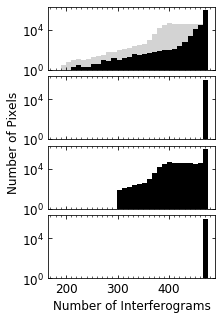

In [6]:
## Figure 14 - Histogram of pixels used in network inversion
proj_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/'
proj_name = sensor.project_name2sensor_name(proj_dir)[1]

# PYSAR
num_pysar = readfile.read(os.path.join(proj_dir, 'GIANT/PYSAR/numInvIfgram.h5'))[0].flatten()
mask_pysar_out = readfile.read(os.path.join(proj_dir, 'GIANT/PYSAR/maskTempCoh.h5'))[0].flatten()
mask_pysar_in = num_pysar != 0.

# GIANT
num_giant = readfile.read(os.path.join(proj_dir, 'GIANT/Stack/NSBAS-PARAMS.h5'), datasetName='ifgcnt')[0].flatten()
num_giant_max = np.max(num_giant)
mask_gsbas = num_giant == num_giant_max
mask_gnsbas = num_giant != 0.
mask_gnsbas *= ~np.isnan(num_giant)
mask_gtimefun = np.array(mask_gsbas)

num_data = (num_pysar[mask_pysar_in],
            num_pysar[mask_pysar_out],
            num_giant[mask_gsbas],
            num_giant[mask_gnsbas],
            num_giant[mask_gtimefun])
labels = ['PYSAR (processed)', 'PYSAR (selected)', 'G-SBAS', 'G-NSBAS', 'G-TimeFun']

# plot
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(3, 5), sharex=True, sharey=True)
for i in [0,1,2,3,4]:
    if i == 0:
        ax = axs[0]
        ax.hist(num_data[i], bins=30, histtype='stepfilled', range=(180,num_giant_max), log=True,
                color='lightgray', lw=1, linestyle='dotted', label=labels[i])
    else:
        ax = axs[i-1]
        ax.hist(num_data[i], bins=30, histtype='stepfilled', range=(180,num_giant_max), log=True,
                color='k', lw=1, label=labels[i])
# axis format
for ax in axs:
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
    ax.set_ylim(bottom=1e0)
axs[-1].set_xlabel('Number of Interferograms', fontsize=font_size)
pp.set_shared_ylabel(axs, 'Number of Pixels', font_size=font_size)
fig.subplots_adjust(hspace=0.1)

out_file = 'hist_numIfgram_{}.png'.format(proj_name)
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

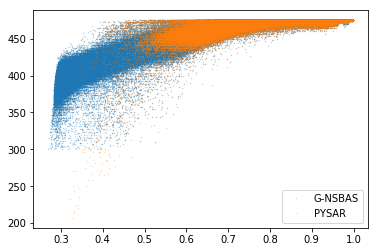

In [6]:
# test
avg_coh_file = os.path.join(proj_dir, 'PYSAR/avgSpatialCoherence.h5')
coh_all = readfile.read(avg_coh_file)[0].flatten()
vel = readfile.read(vel_files[0])[0].flatten()
plt.figure()
plt.plot(coh_all[mask_gnsbas], num_giant[mask_gnsbas], '.', ms=0.5, alpha=0.5, label='G-NSBAS')
plt.plot(coh_all[mask_tcoh],   num_pysar[mask_tcoh],   '.', ms=0.5, alpha=0.5, label='PYSAR')
plt.legend()
plt.show()